In [59]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv('beijing_grouped_daily.csv')
df

,date,year,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,...,WNW,WSW,AQI_PM2.5,AQI_PM10,AQI_CO,AQI_NO2,AQI_SO2,AQI_O3,AQI,weekday
0,2013-03-01,2013.0,11.5,7.261364,13.275486,3.505375,14.341677,0.348265,0.032490,1.093182,...,0.018939,0.000000,23.446285,11.968818,3.957552,13.529884,5.007678,30.083737,35.388329,1.0
1,2013-03-02,2013.0,11.5,31.526515,40.919940,11.294616,28.053480,0.772689,0.015471,0.222348,...,0.034091,0.060606,74.560500,33.772307,8.780553,26.109911,16.135166,14.324617,78.379442,0.0
2,2013-03-03,2013.0,11.5,77.772727,109.344697,17.254908,37.503760,1.419104,0.011585,5.256818,...,0.140152,0.015152,144.025014,77.398620,16.126176,34.947023,24.430721,10.727299,144.425585,0.0
3,2013-03-04,2013.0,11.5,23.176567,41.445940,6.819097,22.596189,0.604732,0.028184,9.626515,...,0.022727,0.018939,60.183106,34.758265,6.871956,20.962543,9.741567,26.096449,64.684175,1.0
4,2013-03-05,2013.0,11.5,129.179116,158.106061,25.174703,51.026083,1.649297,0.037918,6.574621,...,0.041667,0.000000,187.914737,102.096521,18.742008,48.662423,34.819271,35.109718,192.124685,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-02-24,2017.0,11.5,24.279938,37.878400,3.418476,21.716438,0.569965,0.022355,4.850379,...,0.200758,0.037879,64.979397,32.691370,6.476874,20.489548,4.883537,20.698901,66.482887,1.0
1457,2017-02-25,2017.0,11.5,11.770651,22.266852,2.082350,15.123112,0.390930,0.028563,7.021591,...,0.189394,0.071970,36.725308,20.476660,4.442383,14.267087,2.974786,30.928948,46.302496,0.0
1458,2017-02-26,2017.0,11.5,27.816106,45.149427,3.643582,24.807694,0.587603,0.020739,6.729167,...,0.018939,0.030303,74.424945,39.155889,6.677308,23.403485,5.205117,19.202728,74.575859,0.0
1459,2017-02-27,2017.0,11.5,66.816611,97.045753,6.062260,36.852067,1.073475,0.013933,7.699621,...,0.007576,0.030303,139.805923,71.871183,12.198582,34.471493,8.660372,13.816377,142.004456,1.0


In [61]:
beijing_ts = df[['date', 'AQI']]
beijing_ts = beijing_ts.set_index(pd.DatetimeIndex(beijing_ts.date))
del beijing_ts['date']

In [84]:
beijing_ts[beijing_ts['AQI'] == beijing_ts['AQI'].min()]


,AQI
date,
2014-10-12,27.894771


In [64]:
# beijing_ts_gr = beijing_ts.groupby(beijing_ts.index).mean()

In [65]:
# beijing_ts_gr.index.date

In [66]:
def plot_trend_data(ax, df, feature, color_, linestyle):
    ax.plot(df.index.date, df[feature], ':o', color = color_)
    ax.set_xlabel('Date', fontsize=20)
    ax.set_ylabel('AQI Level',fontsize=20)
    ax.set_title("Beijing AQI Trend Plot",fontsize=20)
    #ax.set_ylim((0, 100))

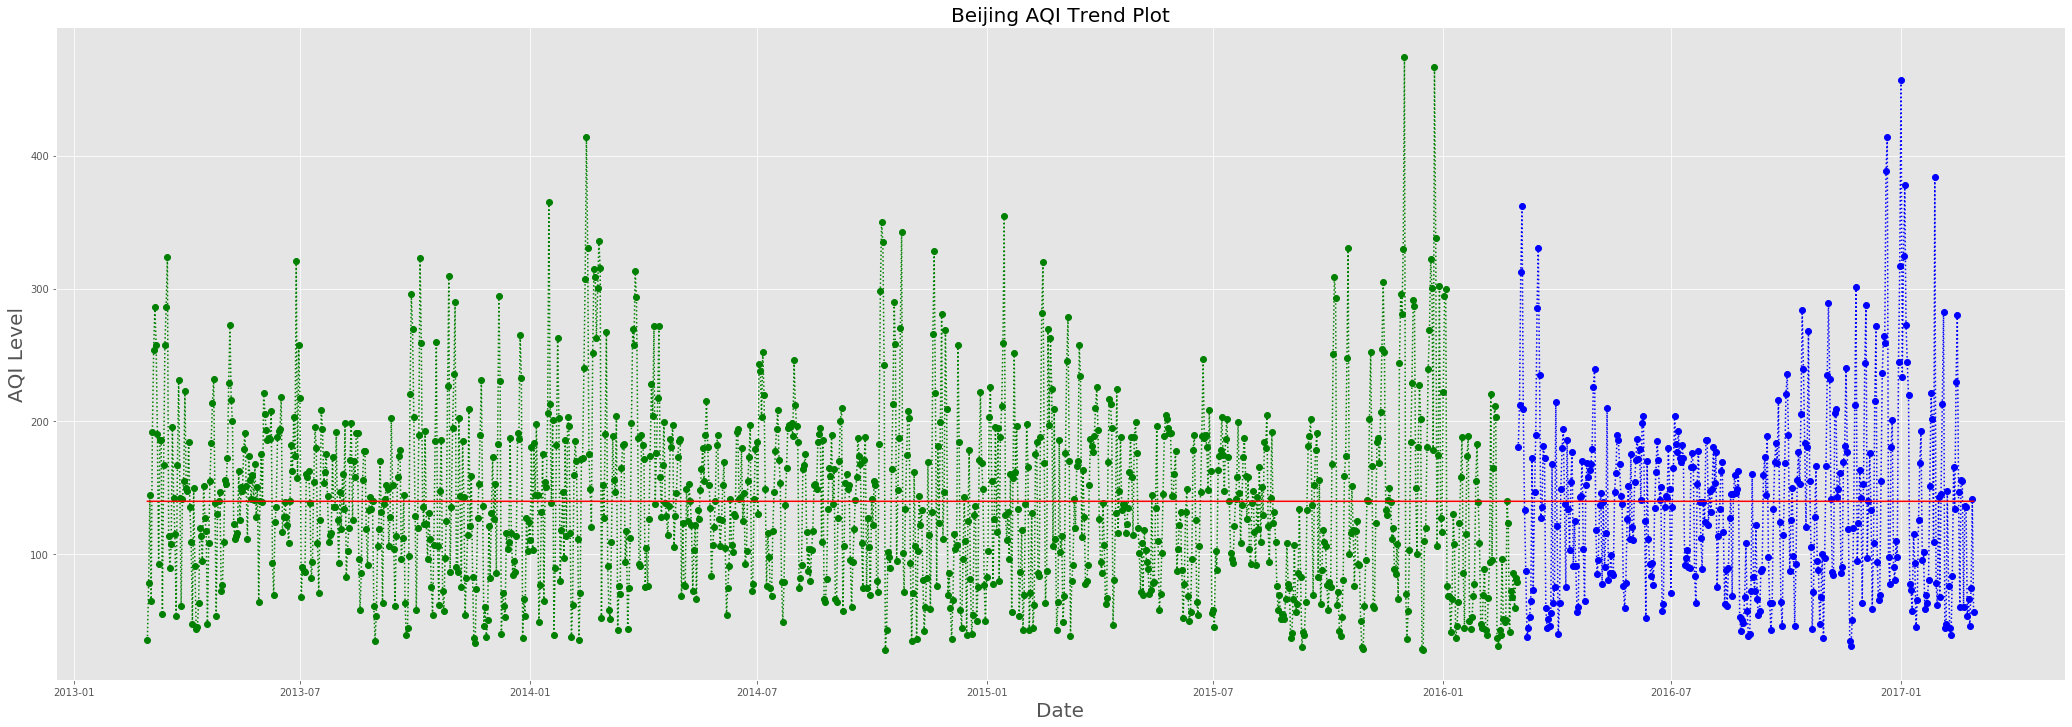

In [67]:
fig, ax = plt.subplots(figsize=(36, 12))
plot_trend_data(ax, beijing_ts.iloc[:-365], 'AQI', 'green')
plot_trend_data(ax, beijing_ts.iloc[-365:], 'AQI', 'blue')
ax.plot(beijing_ts.index.date, [beijing_ts['AQI'].mean()]*len(beijing_ts), color = 'r')
plt.show()




In [85]:
supervised_ts = pd.read_csv('random_forest_ts.csv')
supervised_ts = supervised_ts.set_index(pd.DatetimeIndex(supervised_ts.date))
supervised_ts.drop('date', axis = 1, inplace = True)

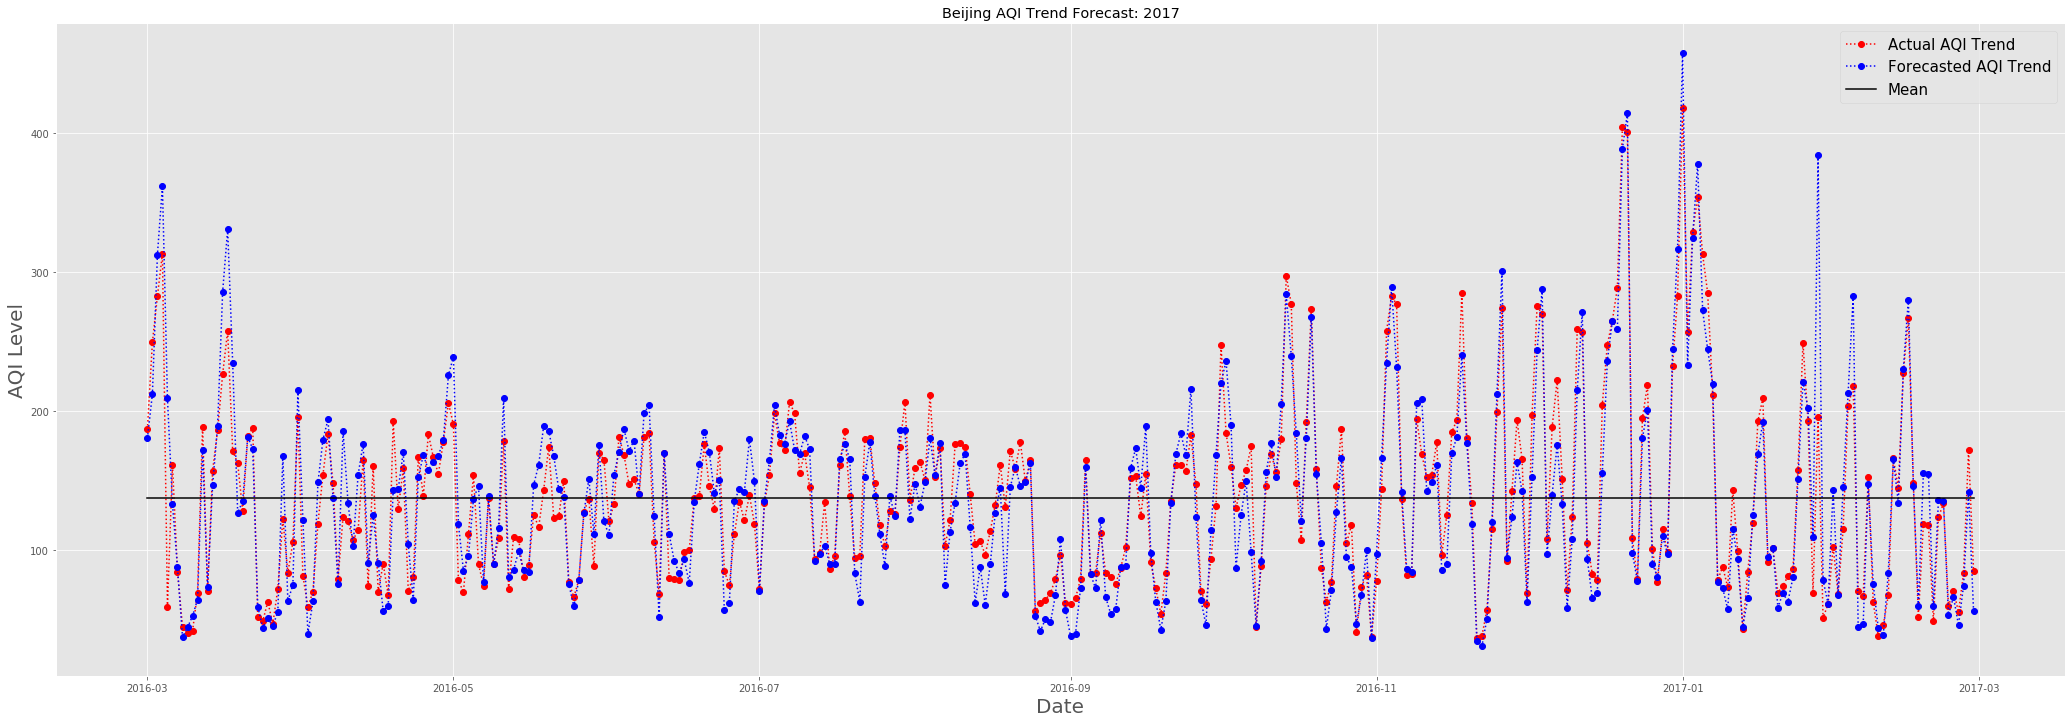

In [86]:
fig, ax = plt.subplots(figsize=(36, 12))
plot_trend_data(ax, supervised_ts, 'preds', 'red')
plot_trend_data(ax, supervised_ts, 'target', 'blue')
ax.plot(supervised_ts.index.date, [supervised_ts['target'].mean()]*len(supervised_ts), color = 'k')
plt.legend(['Actual AQI Trend', 'Forecasted AQI Trend', 'Mean'], fontsize=15)
plt.title('Beijing AQI Trend Forecast: 2017')
plt.savefig('supervised_ts_forecast.png')
plt.show()

In [77]:
supervised_ts.preds

date
2016-03-01    177.573734
2016-03-02    252.587357
2016-03-03    278.361268
2016-03-04    278.497182
2016-03-05     44.463092
                 ...    
2017-02-24     78.012581
2017-02-25     74.506158
2017-02-26     92.315646
2017-02-27    161.832031
2017-02-28     73.943472
Name: preds, Length: 365, dtype: float64

In [110]:
# beijing_ts_gr['AQI_Level'].iloc[:-365]

date
2013-03-01     23.446285
2013-03-02     74.560500
2013-03-03    144.025014
2013-03-04     60.183106
2013-03-05    187.914737
                 ...    
2016-02-25     65.615989
2016-02-26     83.763680
2016-02-27     58.471759
2016-02-28     77.034870
2016-02-29     79.043673
Name: AQI_Level, Length: 1096, dtype: float64

In [21]:
beijing_decomposition = sm.tsa.seasonal_decompose(beijing_ts['aqi'].iloc[:-365])

In [22]:
def plot_shared_yscales(axs, x, ys, titles):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))
        
def plot_seasonal_decomposition(axs, series, sd):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", "Trend Component $T_t$", "Seasonal Component $S_t$", "Residual Component $R_t$"])


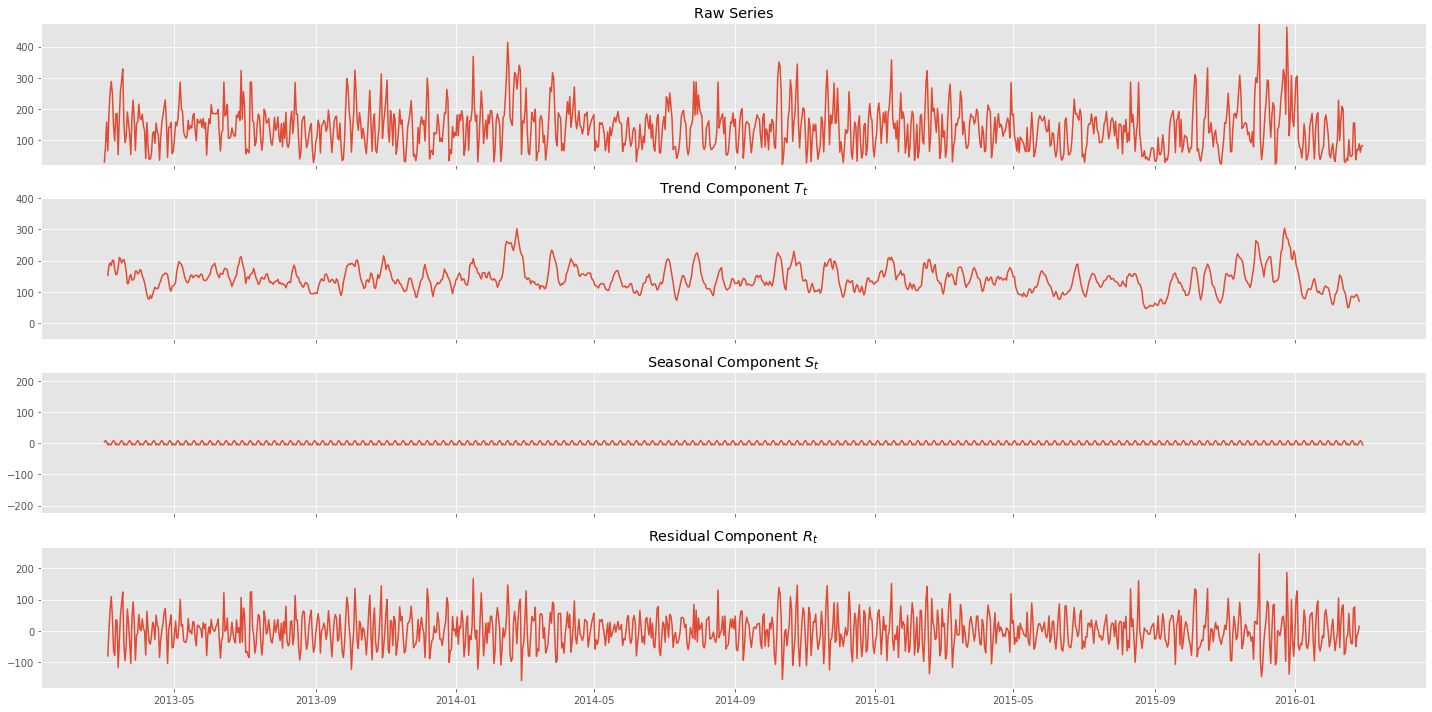

In [24]:
fig, axs = plt.subplots(4, figsize=(20, 10), sharex=True)
plot_seasonal_decomposition(axs, beijing_ts['aqi'].iloc[:-365], beijing_decomposition)
plt.tight_layout()

In [57]:
def fit_moving_average_trend(series, window=30):
#    return pd.rolling_mean(series, window, center=True)
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, series, feature, window=30):
    moving_average_trend = fit_moving_average_trend(series, window)
    ax.plot(series.index.date, moving_average_trend, '-*', color = 'k')

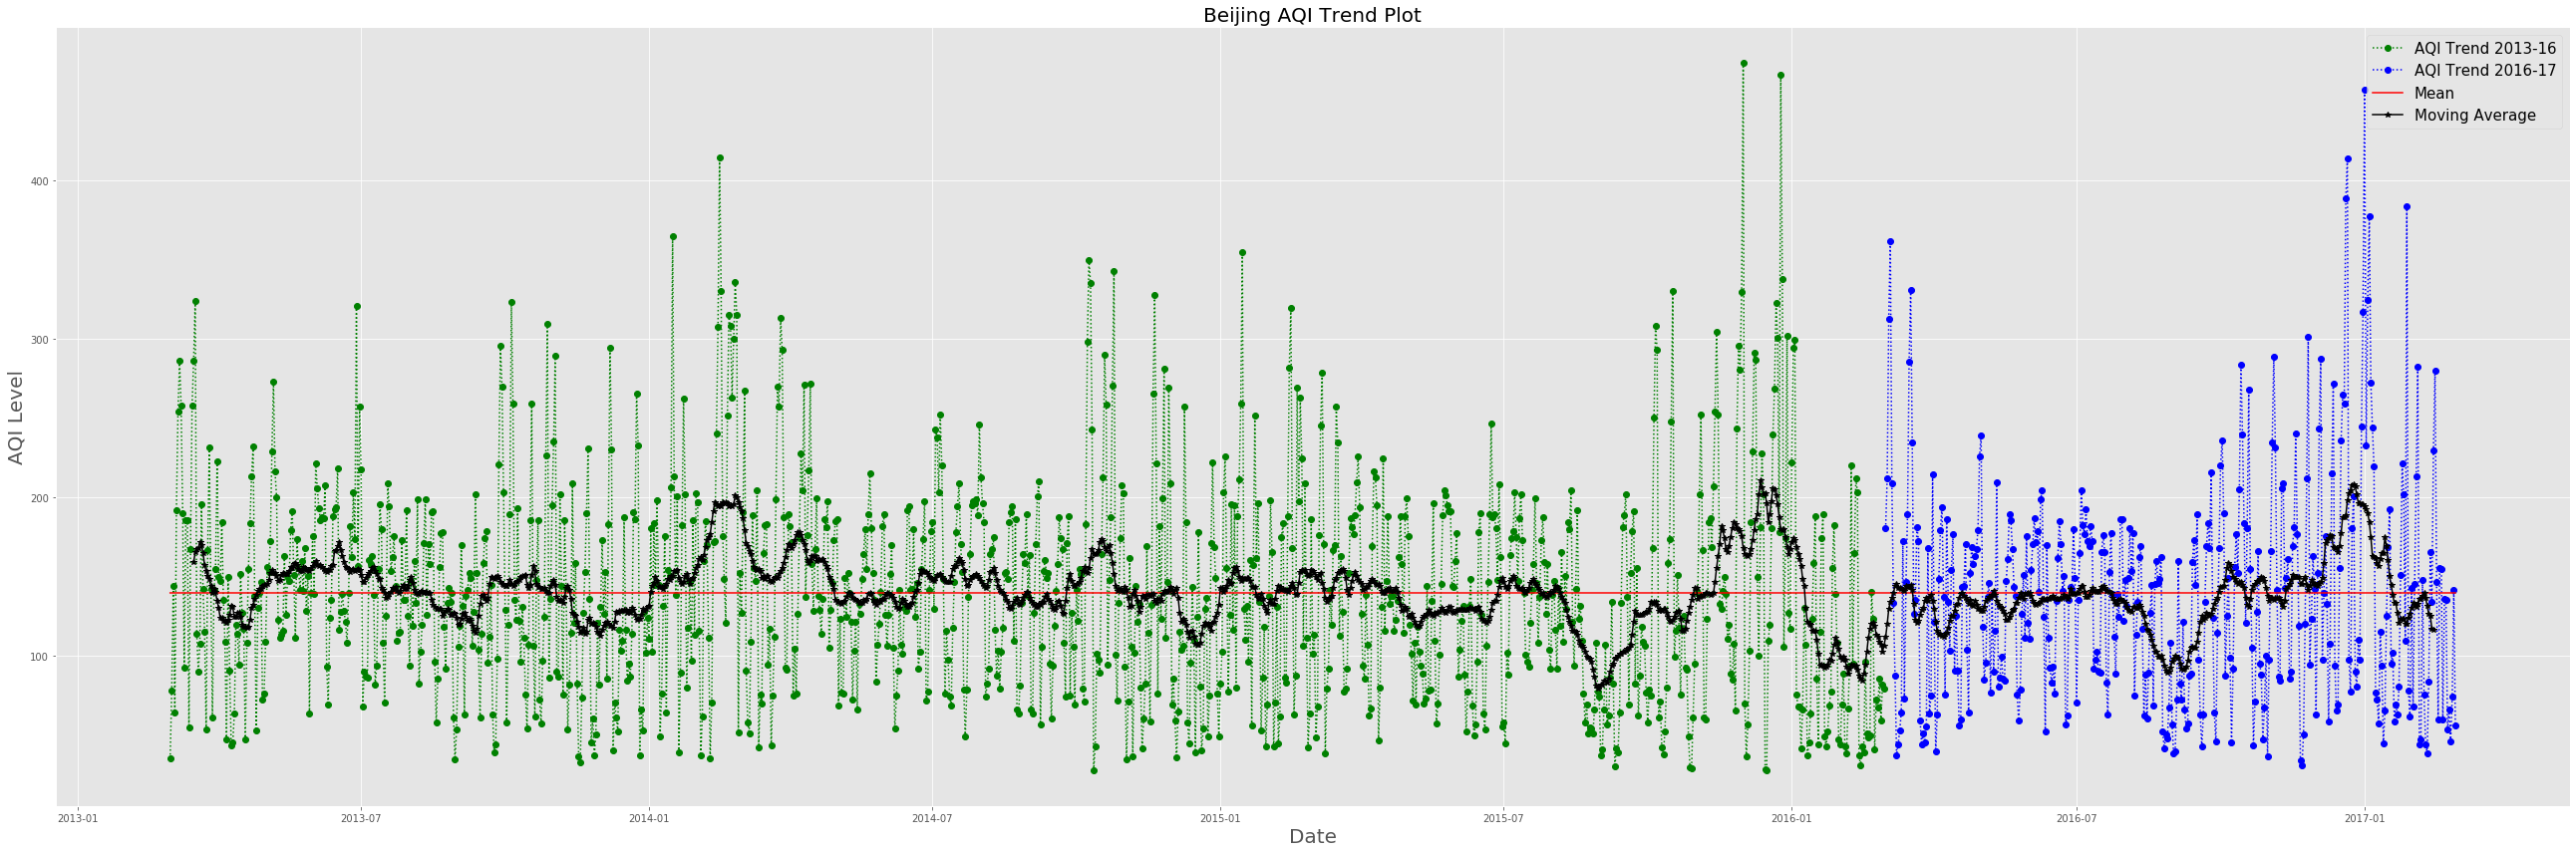

In [58]:
fig, ax = plt.subplots(figsize=(36, 12))
plot_trend_data(ax, beijing_ts.iloc[:-365], 'AQI', 'green')
plot_trend_data(ax, beijing_ts.iloc[-365:], 'AQI', 'blue')
ax.plot(beijing_ts.index.date, [beijing_ts['AQI'].mean()]*len(beijing_ts), color = 'r')
plot_moving_average_trend(ax, beijing_ts, 'AQI')
plt.legend(['AQI Trend 2013-16', 'AQI Trend 2016-17', 'Mean', 'Moving Average'], fontsize=15)
plt.tight_layout()
plt.savefig('beijing_ts.png')
plt.show()